In [1]:
!pip install tensorflow

In [2]:
!pip install -U scikit-learn

In [3]:
# Importando as bibliotecas necessárias
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
from PIL import Image

# Configurando o matplotlib
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [10, 5]

In [4]:
# Download
# https://www.dropbox.com/s/8o4ysiccspp46ov/skin-cancer-mnist-ham10000.zip?dl=1

# Load the metadata
metadata = pd.read_csv('data/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

# Print the first 5 rows of the metadata
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
# Preparação dos dados

# Carregar as imagens e os rótulos
images = []
labels = []

# Caminho para as imagens
image_path = 'data/skin-cancer-mnist-ham10000/HAM10000_images_part_1/'

# Loop através de todas as imagens no diretório
for img in os.listdir(image_path):
    # Carregar a imagem
    image = Image.open(image_path + img)
    # Redimensionar a imagem para 32x32 pixels
    image = image.resize((32, 32))
    # Converter a imagem para array numpy
    image = np.array(image)
    # Adicionar a imagem à lista de imagens
    images.append(image)

    # Adicionar o rótulo à lista de rótulos
    labels.append(metadata[metadata['image_id'] == img.split('.')[0]]['dx'].values[0])

# Converter listas em arrays numpy
images = np.array(images)
labels = np.array(labels)

# Print the shape of the images and labels
print('Images shape:', images.shape)
print('Labels shape:', labels.shape)

Images shape: (5000, 32, 32, 3)
Labels shape: (5000,)


In [6]:
# Codificar os rótulos
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = to_categorical(labels)

# Dividir os dados em conjuntos de treinamento, validação e teste
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, stratify=labels, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Print the shape of the train, validation and test sets
print('Train set shape:', x_train.shape, y_train.shape)
print('Validation set shape:', x_val.shape, y_val.shape)
print('Test set shape:', x_test.shape, y_test.shape)

Train set shape: (2800, 32, 32, 3) (2800, 7)
Validation set shape: (700, 32, 32, 3) (700, 7)
Test set shape: (1500, 32, 32, 3) (1500, 7)


In [7]:
# Definindo a arquitetura da rede
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [8]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

# Compilando o modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

In [9]:
# Treinando o modelo
history = model.fit(
    x_train, y_train,
    epochs=1000,
    batch_size=16,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping],
    verbose=1
    )

Epoch 1/1000
175/175 [==============================] - 2s 8ms/step - loss: 1.9888 - accuracy: 0.6511 - val_loss: 0.9191 - val_accuracy: 0.6800
Epoch 2/1000
175/175 [==============================] - 1s 7ms/step - loss: 0.9360 - accuracy: 0.6882 - val_loss: 0.9060 - val_accuracy: 0.6943
Epoch 3/1000
175/175 [==============================] - 1s 7ms/step - loss: 0.8804 - accuracy: 0.7007 - val_loss: 0.8929 - val_accuracy: 0.6814
Epoch 4/1000
175/175 [==============================] - 1s 7ms/step - loss: 0.8516 - accuracy: 0.7025 - val_loss: 0.8355 - val_accuracy: 0.7014
Epoch 5/1000
175/175 [==============================] - 1s 7ms/step - loss: 0.8261 - accuracy: 0.7029 - val_loss: 0.8419 - val_accuracy: 0.7029
Epoch 6/1000
175/175 [==============================] - 1s 7ms/step - loss: 0.8033 - accuracy: 0.7161 - val_loss: 0.8581 - val_accuracy: 0.6914
Epoch 7/1000
175/175 [==============================] - 1s 7ms/step - loss: 0.7724 - accuracy: 0.7250 - val_loss: 0.8453 - val_accuracy:

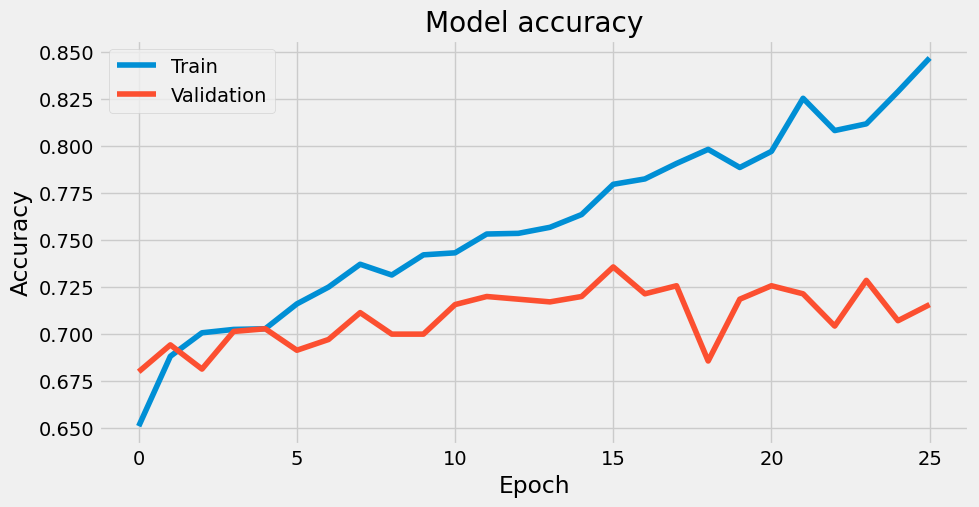

In [10]:
# Plotando a acurácia de treinamento e validação ao longo das épocas
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [11]:
# Avaliando o modelo no conjunto de teste
test_loss, test_acc = model.evaluate(x_test, y_test)

print('Test accuracy:', test_acc)

47/47 [==============================] - 0s 4ms/step - loss: 0.9958 - accuracy: 0.7167
Test accuracy: 0.7166666388511658
